# EM estimation using Inside-Outside

This notebook essentially builts forward on the notebook lab-inference.ipynb. (All code is mine unless explicitly noted).

In [2]:
from rule import Rule
from cfg import WCFG, read_grammar_rules
from parser import cky
from earley import earley
from symbol import make_symbol, is_nonterminal, is_terminal
import numpy as np
from collections import defaultdict

In [22]:
# let's use the ambiguous grammar
G = WCFG(read_grammar_rules(open('examples/ambiguous', 'r')))
print G

[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [8]:
sentence = 'a + a * a'.split()
sentence

['a', '+', 'a', '*', 'a']

In [9]:
forest = cky(G, sentence)
print forest

[E:2-3] -> [T:2-3] (0.5)
[E:4-5] -> [T:4-5] (0.5)
[T:0-3] -> [T:0-1] + [P:2-3] (0.1)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[E:0-5] -> [T:0-5] (0.5)
[E:0-5] -> [E:0-3] * [T:4-5] (0.05)
[E:0-5] -> [E:0-1] + [T:2-5] (0.45)
[T:0-1] -> [P:0-1] (0.5)
[E:0-1] -> [T:0-1] (0.5)
[E:0-3] -> [E:0-1] + [T:2-3] (0.45)
[E:0-3] -> [T:0-3] (0.5)
[E:2-5] -> [E:2-3] * [T:4-5] (0.05)
[E:2-5] -> [T:2-5] (0.5)
[P:0-1] -> a (1.0)
[T:4-5] -> [P:4-5] (0.5)
[P:2-3] -> a (1.0)
[T:2-5] -> [T:2-3] * [P:4-5] (0.4)
[T:2-3] -> [P:2-3] (0.5)
[P:4-5] -> a (1.0)


Reminder: the goal symbol after parsing is the original *start* symbol annotated from *0* to *n* (the length of the sentence).

In [11]:
goal = make_symbol('[E]', 0, len(sentence))
goal

'[E:0-5]'

We can also use earley to parse the sentence. For this we also need to pass the parser the start symbol that we are using, as earley uses this to produce its axioms.

In [8]:
earley_forest = earley(G, sentence, start='[E]')
print earley_forest

[T:0-3] -> [T:0-1] + [P:2-3] (0.1)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[E:0-5] -> [T:0-5] (0.5)
[E:0-5] -> [E:0-3] * [T:4-5] (0.05)
[E:0-5] -> [E:0-1] + [T:2-5] (0.45)
[T:0-1] -> [P:0-1] (0.5)
[E:0-1] -> [T:0-1] (0.5)
[E:0-3] -> [E:0-1] + [T:2-3] (0.45)
[E:0-3] -> [T:0-3] (0.5)
[P:0-1] -> a (1.0)
[T:4-5] -> [P:4-5] (0.5)
[P:2-3] -> a (1.0)
[T:2-5] -> [T:2-3] * [P:4-5] (0.4)
[T:2-3] -> [P:2-3] (0.5)
[P:4-5] -> a (1.0)


Notice that the forest generated by Earley are smaller than the forest generated by CKY: Earley has a built-in top-down filter that removes redundant elements.

In [10]:
print len(forest)
print len(earley_forest)

19
15


# Generate a corpus

We can use a grammar generate a corpus using ancestral sampling. Here we use the ambiguous grammar given above.

In [4]:
def generate_sample(grammar, items=('[E]',)):
    """
    Given a grammar returns a sentence from it using
    the probabilities specfied in the grammar.
    :param items: call the function with (start,) where 
                  start is the start symbol of the grammar
    :returns: a sentence from the language as a list
    """
    frags = []
    for item in items:
        if is_nonterminal(item):
            productions = grammar.get(item)
            ps = [production.prob for production in productions]
            random_index = np.argmax(np.random.multinomial(1, ps, size=1))
            prod = productions[random_index]
            frags.extend(generate_sample(grammar, items=prod.rhs))
        else:
            frags.append(item)
    return frags

# print generate_sample(G)

def generate_corpus(grammar, n, start=('[E]',),):
    """
    Generates a corpus using the grammar
    :param n: size of the corpus
    :params: same a s generate corpus
    :returns: a corpus in the form of a list
    """
    return [generate_sample(grammar, items=start) for i in range(n)]

corpus1 = generate_corpus(G, 100)
corpus2 = generate_corpus(G, 1000)
corpus3 = generate_corpus(G, 10000)

print corpus1

[['a', '*', 'a', '+', 'a'], ['a'], ['a'], ['a', '*', 'a', '+', 'a'], ['a', '*', 'a', '+', 'a', '+', 'a'], ['a', '*', 'a', '*', 'a', '+', 'a', '+', 'a'], ['a', '*', 'a'], ['a', '+', 'a', '*', 'a', '*', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '*', 'a', '+', 'a', '+', 'a'], ['a', '*', 'a', '*', 'a', '+', 'a', '+', 'a'], ['a', '+', 'a'], ['a', '*', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '+', 'a', '+', 'a', '*', 'a', '+', 'a', '+', 'a', '*', 'a', '+', 'a', '*', 'a'], ['a', '+', 'a', '*', 'a', '*', 'a'], ['a'], ['a'], ['a', '+', 'a', '*', 'a'], ['a', '+', 'a', '+', 'a', '+', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '+', 'a'], ['a'], ['a'], ['a', '+', 'a'], ['a', '*', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '+', 'a'], ['a', '*', 'a', '*', 'a'], ['a'], ['a', '*', 'a', '*', 'a', '*', 'a', '+', 'a', '+', 'a', '+', 'a', '*', 'a'], ['a', '*', 'a', '+', 'a', '+', 'a', '+', '

# Inside weights

(Author: Wilker Aziz)

The inside recursion accumulates the weight of all subtrees under a certain node.

        I(v) = 
            1                           if v is terminal
            0                           if v is nonterminal and BS(v) is empty
            
$$\sum_{e \in BS(v)} w(e) \prod_{u \in tail(e)} I(u)$$
                                        otherwise
                                        
Here we are going to compute inside weights for acyclic forests, for a more general treatment see Goodman's "Semiring Parsing" paper (1999).

Inside weights can be used, for instance, to answer the question:

* what is the probability of sentence x?

It can also be used to find the best derivation and to sample derivations, as we will show below.

In [5]:


def inside(forest, start):  # acyclic hypergraph
    
    """
    Author: Wilker Aziz
    
    The inside recursion for acyclic hypergraphs.
    
    :param forest: an acyclic WCFG
    :param start: the start symbol (str)
    :returns: a dictionary mapping a symbol (terminal or noterminal) to its inside weight
    """
    I = dict()
    
    def get_inside(symbol):
        """computes inside recursively"""
        w = I.get(symbol, None)
        if w is not None:  # already computed
            return w
        incoming = forest.get(symbol, set())
        if len(incoming) == 0:  # terminals have already been handled, this must be a nonterminal dead end
            # store it to avoid repeating computation in the future
            I[symbol] = 0.0
            return 0.0
        # accumulate the inside contribution of each incoming edge
        w = 0.0
        for rule in incoming:
            k = rule.prob
            for child in rule.rhs:
                k *= get_inside(child)
            w += k
        # store it to avoid repeating computation in the future
        I[symbol] = w
        return w
    
    # handles terminals
    for sym in forest.terminals:
        I[sym] = 1.0
    # recursively solves the inside formula from the start symbol
    get_inside(start)
        
    return I

The inside at the root represents the probability of the sentence:
$$p(x) = \sum_d p(x, d)$$

In [12]:
I = inside(forest, goal)

print I

{'a': 1.0, '[T:0-3]': 0.05, '[T:0-5]': 0.020000000000000004, '[E:0-5]': 0.034531250000000006, '[T:0-1]': 0.5, '+': 1.0, '*': 1.0, '[E:0-3]': 0.08125, '[T:2-3]': 0.5, '[P:0-1]': 1.0, '[T:4-5]': 0.5, '[P:2-3]': 1.0, '[T:2-5]': 0.2, '[E:0-1]': 0.25, '[P:4-5]': 1.0}


# Outside weights

Computing outside probabilities.


In [13]:
def get_rules_by_rhs(grammar, symbol):
    rules = []
    for rule in grammar:
#         print rule
        if symbol in rule.rhs:
            rules.append(rule)
    return rules

print get_rules_by_rhs(forest, '[T:2-5]')

[[E:0-5] -> [E:0-1] + [T:2-5] (0.45), [E:2-5] -> [T:2-5] (0.5)]


In [14]:
def outside(forest, start, inside_dict):
    
    I = dict()
    
    def get_outside(symbol):
        w = I.get(symbol, None)
        if w is not None:  # already computed
            return w
        outgoing = get_rules_by_rhs(forest, symbol)
        beta = 0.0
        for rule in outgoing:
            k = rule.prob
            for child in rule.rhs:
                if child != symbol:
                    try:
                        alpha = inside_dict[child]
                    except KeyError:
                        # Not sure about this solution...
                        # If child is not in inside_dict then child was not seen in the top-down process
                        # of the inside algorithm, and hence there is no way to complete child into a 
                        # parse for the whole sentence. So beta should be 0.0
#                         print "key-error with {}".format(child)
                        alpha = 0.0
                    k *= alpha
            k *= get_outside(rule.lhs)
            beta += k
        I[symbol] = beta
        return beta
    
    I[start] = 1.0
    
    for sym in forest.terminals:
#         print "terminal: {}".format(sym)
        I[sym] = get_outside(sym)
    
    return I

In [21]:
print outside(forest, goal, I)

{'a': 0.10359375000000001, '[E:2-3]': 0.0, '[E:4-5]': 0.0, '[T:0-3]': 0.21250000000000002, '[T:0-5]': 0.5, '[E:0-5]': 1.0, '[T:0-1]': 0.06906250000000001, '[E:0-1]': 0.09562500000000002, '*': 0.03453125, '[E:0-3]': 0.025, '[T:4-5]': 0.0040625, '[P:0-1]': 0.034531250000000006, '[P:2-3]': 0.034531250000000006, '[E:2-5]': 0.0, '[T:2-5]': 0.1125, '+': 0.034531250000000006, '[T:2-3]': 0.04781250000000001, '[P:4-5]': 0.03453125}


# Inside-Outside

We use the inside-outside algorithm to learn probabilities of the rules from unlabeled data.

In [15]:
def initialize(grammar, alpha=0.5):
    """
    Takes a grammar and returns that same grammar but
    with the probabilities replaced by random probabilities
    generated from a Dirichlet distribution.
    :param: alpha is the Dirichlet concentration parameter
    """
    init_grammar = WCFG()
    for nonterminal in grammar.nonterminals:
        rules = grammar.get(nonterminal)
        init_prob = np.random.dirichlet(len(rules)*[alpha])
        for i, rule in enumerate(rules):
            init_grammar.add(Rule(rule.lhs, rule.rhs, init_prob[i]))
    return init_grammar

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_instances(rule, forest):
    """
    Given a rule
    
    A -> B C 
    
    get_instances collects all instances of rules of the form
    
    [A:i-j] -> [B:i-k] [C:k-j] 
    
    from the forest and returns them in a list.
    """
    instances = []
    for r in forest:
        if r.lhs[1] == rule.lhs[1] and len(r.rhs)==len(rule.rhs):
            test = []
            for i in range(len(r.rhs)):
                try:
                    # if for example r.rhs[i] = '[A]' 
                    v = r.rhs[i][1] == rule.rhs[i][1]
                    test.append(v)
                except IndexError:
                    # if for example r.rhs[i] = '*' 
                    v = r.rhs[i][0] == rule.rhs[i][0]
                    test.append(v)
            if np.all(test):
                instances.append(r)
    return instances

def inside_outside(training_sents, grammar, start_sym='[E]'):
    f = defaultdict(float)
    for sent in training_sents:
        forest = cky(grammar, sent)
        goal = make_symbol(start_sym, 0, len(sent))
        I = inside(forest, goal)
        O = outside(forest, goal, I)     
        for rule in grammar:
            w = 0.0
            for instance in get_instances(rule, forest):
                k = instance.prob
                k *= O[instance.lhs]
                for child in instance.rhs:
                    try:
                        alpha = I[child]
                    except KeyError:
                        # same solution as in outside
                        alpha = 0.0
                    k *= alpha
                w += k
            f[rule] += w/I[goal]
    return f

def EM(training_sents, grammar, n, start_sym='[E]', prin=False):
    if prin == True:
        print "Initalized grammar:\n{}\n".format(grammar)
    step = 0
    while step < n:
        
        # E-step
        f = inside_outside(training_sents, grammar, start_sym=start_sym)
                
        #M-step
        new_grammar = WCFG()
        for rule in grammar:
            new_prob = f[rule]/sum([f[r] for r in grammar.get(rule.lhs)])
            new_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))
        
        grammar = new_grammar
        
        step +=1   
    return grammar

## Plotting progress

We use pyplot to show the progress in the parameter estimation. 

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_EM(corpus, grammar, n, start_sym='[E]', init=False):
    
    d = defaultdict(list)
    for rule in grammar: # save the true grammar probs
        ruled = Rule(rule.lhs, rule.rhs, 1.0) # make sure the dict entries do not depend on the rule probs
        d[ruled].append(rule.prob)
    
    if init == True:
        # initialize a random grammar based on grammar
        grammar = initialize(grammar)
    
    i = 0
    while i < n:
        print "round {}".format(i)
        new_grammar = EM(corpus, grammar, 1, start_sym=start_sym, prin=False)
        for rule in new_grammar:
            ruled = Rule(rule.lhs, rule.rhs, 1.0)
            d[ruled].append(rule.prob)
#             print "rule {0}, prob {1}, rule-prob {2}".format(rule, d[ruled], rule.prob)
        
#         grammar = WCFG()
#         for rule in new_grammar:
#             grammar.add(rule)
        grammar = new_grammar
        i += 1

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    i = 0
    for rule, prob in d.iteritems():
        plt.plot(range(n+1), prob, color=colors[i%len(colors)])
        plt.plot(range(n+1), [prob[0]]*(n+1), '--', color=colors[i%len(colors)])
        i += 1
        
    plt.show()


round 0
round 1
round 2


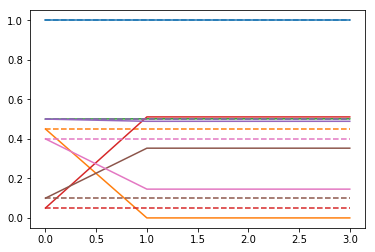

In [102]:
plot_EM(corpus1, G, 3, init=True)

## Why is this not working?

There seems to be a problem with the EM: only the first run changes the parameters; all later runs keep them identical. 

Below I investigate this and try to find the bug. I have not been succesfull yet however...

In [54]:
init_grammar = initialize(G)

In [103]:
print "init_grammar:"
print init_grammar
print '\n'

print 'f_init:'
f = inside_outside(corpus1, init_grammar, start_sym='[E]')
for rule, value in f.iteritems():
    print rule, value
print '\n'

new_grammar = WCFG()
for rule in init_grammar:
    print "rule: {0}\t f[rule]: {1}\t sum: {2}\t".format(rule, 
                                                         f[rule], 
                                                         sum([f[r] for r in init_grammar.get(rule.lhs)]))
    new_prob = f[rule]/sum([f[r] for r in init_grammar.get(rule.lhs)])
    new_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))
print "\nnew_grammar:"
print new_grammar
print '\n'

print 'f_new:'
f_new = inside_outside(corpus1, new_grammar, start_sym='[E]')
for rule, value in f_new.iteritems():
    print rule, value
print '\n'

newnew_grammar = WCFG()
for rule in new_grammar:
    print "rule: {0}\t f[rule]: {1}\t sum: {2}\t".format(rule, 
                                                         f_new[rule], 
                                                         sum([f_new[r] for r in new_grammar.get(rule.lhs)]))
    new_prob = f_new[rule]/sum([f_new[r] for r in new_grammar.get(rule.lhs)])
    newnew_grammar.add(Rule(rule.lhs, rule.rhs, new_prob))

print "\nnew_new_grammar:"
print newnew_grammar
print '\n'


init_grammar:
[T] -> [P] (0.000473491343677)
[T] -> [T] * [P] (0.553670923623)
[T] -> [T] + [P] (0.445855585033)
[E] -> [T] (0.559683910819)
[E] -> [E] + [T] (0.187256900197)
[E] -> [E] * [T] (0.253059188984)
[P] -> a (1.0)


f_init:
[P] -> a (1.0) 408.0
[E] -> [E] + [T] (0.187256900197) 0.0286306888768
[E] -> [T] (0.559683910819) 100.0
[T] -> [T] * [P] (0.553670923623) 163.964516021
[T] -> [T] + [P] (0.445855585033) 143.971369311
[T] -> [P] (0.000473491343677) 100.064114668
[E] -> [E] * [T] (0.253059188984) 0.0354839787195


rule: [T] -> [P] (0.000473491343677)	 f[rule]: 100.064114668	 sum: 408.0	
rule: [T] -> [T] * [P] (0.553670923623)	 f[rule]: 163.964516021	 sum: 408.0	
rule: [T] -> [T] + [P] (0.445855585033)	 f[rule]: 143.971369311	 sum: 408.0	
rule: [E] -> [T] (0.559683910819)	 f[rule]: 100.0	 sum: 100.064114668	
rule: [E] -> [E] + [T] (0.187256900197)	 f[rule]: 0.0286306888768	 sum: 100.064114668	
rule: [E] -> [E] * [T] (0.253059188984)	 f[rule]: 0.0354839787195	 sum: 100.064114

## Training on a natural language grammar

In [20]:
hdp_pcfg = WCFG(read_grammar_rules(open('examples/hdp-pcfg-grammar', 'r')))
print hdp_pcfg
hdp_corpus = generate_corpus(hdp_pcfg, 100, start=('[S]',))
print '\nSome sentences generated by the grammar:\n'
for i in range(3):
    print hdp_corpus[i]

[NN] -> mouse (0.33)
[NN] -> cat (0.33)
[NN] -> dog (0.34)
[JJ] -> big (0.5)
[JJ] -> black (0.5)
[DT] -> the (0.5)
[DT] -> a (0.5)
[NPBAR] -> [JJ] [NN] (0.5)
[NPBAR] -> [JJ] [NPBAR] (0.5)
[VP] -> [VB] [NP] (1.0)
[S] -> [NP] [VP] (1.0)
[VB] -> chased (0.5)
[VB] -> ate (0.5)
[NP] -> [DT] [NN] (0.5)
[NP] -> [DT] [NPBAR] (0.5)

Some sentences generated by the grammar:

['the', 'black', 'mouse', 'ate', 'a', 'black', 'big', 'dog']
['the', 'big', 'black', 'cat', 'chased', 'a', 'dog']
['the', 'dog', 'chased', 'a', 'black', 'mouse']


round 0
round 1
round 2


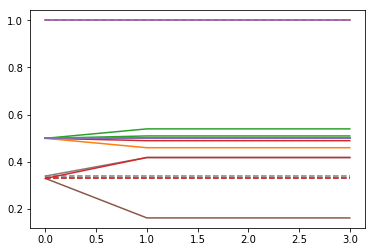

In [21]:
plot_EM(hdp_corpus, hdp_pcfg, 3, start_sym='[S]', init=True)

## Training on the NLTK toy-grammar

Here we generate a corpus from a grammar taken from the NLTK toolkit. We use a Dirichlet distribution to give the productions random probabilities. Larger alpha gives more uniform distributions; smaller alpha gives more biased distributions. 

In [32]:
toy_grammar = WCFG(read_grammar_rules(open('examples/nltk-grammar', 'r')))
# print toy_grammar

# We give the grammar some random probabilities 
# that are not too uniform and moderately biased:
toy_grammar = initialize(toy_grammar, alpha=0.5)
print toy_grammar

[PP] -> [P] [NP] (1.0)
[N] -> boy (0.0296057898203)
[N] -> cookie (0.327153840769)
[N] -> table (0.15643736648)
[N] -> telescope (0.136339725333)
[N] -> hill (0.350463277597)
[VP] -> [V] [NP] (0.673929023594)
[VP] -> [V] (0.110085414778)
[VP] -> [VP] [PP] (0.215985561629)
[V] -> saw (0.736539580502)
[V] -> ate (0.230243141692)
[V] -> ran (0.0332172778065)
[Name] -> Bob (0.19425294971)
[Name] -> Jack (0.80574705029)
[Det] -> the (0.978510152527)
[Det] -> a (0.0204459747726)
[Det] -> my (0.00104387270073)
[S] -> [NP] [VP] (1.0)
[P] -> with (0.863229071555)
[P] -> under (0.136770928445)
[NP] -> [Det] [N] (0.772589057417)
[NP] -> [Name] (0.225635714322)
[NP] -> [NP] [PP] (0.00177522826084)


From this grammar we can also generate a corpus. Note that the sentences can have an enormous number of different parses. The grammar can quite easliy generate very long sentences, and is very ambiguous.

In [23]:
def counting(forest, start):  # acyclic hypergraph
    """
    Author: Wilker Aziz
    Taken from lab-inference.ipynb
    """
    N = dict()
    
    def get_count(symbol):
        w = N.get(symbol, None)
        if w is not None:
            return w
        incoming = forest.get(symbol, set())
        if len(incoming) == 0:  # terminals have already been handled, this must be a nonterminal dead end
            N[symbol] = w
            return 0
        w = 0
        for rule in incoming:
            k = 1
            for child in rule.rhs:
                k *= get_count(child)
            w += k
        N[symbol] = w
        return w
    
    # handles terminals
    for sym in forest.terminals:
        N[sym] = 1
    # handles nonterminals
    #for sym in forest.nonterminals:
    #    get_inside(sym)
    get_count(start)
        
    return N

In [45]:
generate_sample(toy_grammar, items=('[S]',))
toy_corpus = generate_corpus(toy_grammar, 100, start=('[S]',))
print toy_corpus[0:10]

def checking_number_parses(n=100):
    number = list()
    for sentence in toy_corpus[0:n]:
        toy_forest = cky(toy_grammar, sentence)
        toy_goal = make_symbol('[S]', 0, len(sentence))
        N_toy = counting(toy_forest, toy_goal)
        number.append(N_toy[toy_goal])
    return number

print checking_number_parses()

[['the', 'hill', 'saw', 'the', 'telescope'], ['the', 'hill', 'saw', 'Jack', 'with', 'the', 'hill'], ['the', 'cookie', 'saw', 'Jack'], ['the', 'table', 'ate', 'the', 'telescope'], ['the', 'cookie', 'saw', 'the', 'telescope', 'with', 'the', 'cookie', 'with', 'the', 'hill'], ['the', 'hill', 'saw', 'the', 'hill'], ['Bob', 'ate', 'with', 'the', 'cookie'], ['the', 'cookie', 'saw', 'Jack'], ['the', 'cookie', 'ate', 'the', 'hill'], ['the', 'cookie', 'ate']]
[1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2]


In [46]:
init_toy_grammar = initialize(toy_grammar)
# print init_toy_grammar

approx_grammar = EM(toy_corpus, init_toy_grammar, 1, start_sym='[S]', prin=True)
print '\nApproximated grammar:'
print approx_grammar
print '\nOriginal grammar:'
print toy_grammar

def difference_grammar(one, another):
    diff_grammar = WCFG()
    for rule in one:
        for r in another:
            if r.rhs == rule.rhs and r.lhs == rule.lhs:
                approx_prob = r.prob
                break
        diff_grammar.add(Rule(rule.lhs, rule.rhs, abs(rule.prob-approx_prob)))
    return diff_grammar

print '\nDifference grammar:'
print difference_grammar(toy_grammar, approx_grammar)

Initalized grammar:
[PP] -> [P] [NP] (1.0)
[N] -> boy (0.40766118212)
[N] -> cookie (0.0113249270264)
[N] -> table (0.221688604954)
[N] -> telescope (0.155110950027)
[N] -> hill (0.204214335873)
[Det] -> the (0.284674437759)
[Det] -> a (0.71403694737)
[Det] -> my (0.00128861487122)
[V] -> saw (0.764847690343)
[V] -> ate (0.00205289484053)
[V] -> ran (0.233099414817)
[Name] -> Bob (0.997424823817)
[Name] -> Jack (0.00257517618278)
[VP] -> [V] [NP] (0.792730416705)
[VP] -> [V] (0.00443655114493)
[VP] -> [VP] [PP] (0.20283303215)
[S] -> [NP] [VP] (1.0)
[P] -> with (0.290967841163)
[P] -> under (0.709032158837)
[NP] -> [Det] [N] (0.340651181316)
[NP] -> [Name] (0.549476647475)
[NP] -> [NP] [PP] (0.109872171209)


Approximated grammar:
[PP] -> [P] [NP] (1.0)
[N] -> boy (0.464286640062)
[N] -> cookie (0.0128979960532)
[N] -> table (0.504168974444)
[N] -> telescope (0.00450085262363)
[N] -> hill (0.0141455368171)
[Det] -> the (0.960893854749)
[Det] -> a (0.0391061452514)
[Det] -> my (0.0)
[V]